In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

from tqdm.notebook import tqdm

import h5py

import data
import masks
import inference
import models

%load_ext autoreload
%autoreload 2

In [2]:
fs = 50   # sampling frequency
dx = 4    # channel spacing

assert dx == 4 or dx == 20, "the notebook is only configured for dx=4 or dx=20"

In [ ]:
test_path = './data/preprocessed/real_test/'
test_paths = sorted([test_path + f for f in os.listdir(test_path)])

indices = [6250,6750,6250,5250,7250,5500]
test_data = []
for i, (p, idx) in enumerate(zip(test_paths, indices)):
    with h5py.File(p, 'r') as hf:
        DAS_sample = hf['DAS'][81:,idx-1024:idx+1024]
        if dx == 20:
            DAS_sample = DAS_sample[::5]
        test_data.append(DAS_sample)
test_data = np.stack(test_data)[[2,3,5,0,1,4]]

gutter = 100
test_data = np.pad(test_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
test_data = data.bandpass(test_data, low=1.0, high=10.0, fs=50, gutter=gutter)
test_scale = test_data.std(axis=-1, keepdims=True)
test_data /= test_scale

test_data = torch.from_numpy(test_data.copy())
test_scale = torch.from_numpy(test_scale.copy())

fig, axs = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(6,12))
for i in range(6):
    axs[i].imshow(test_data[i].numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

In [4]:
# load the data

train_path = './data/preprocessed/real_train/'
test_path = './data/preprocessed/real_test/'
train_paths = sorted([train_path + f for f in os.listdir(train_path)])
test_paths = sorted([test_path + f for f in os.listdir(test_path)])

train_real_data = []
for i, p in enumerate(train_paths):
    with h5py.File(p, 'r') as hf:
        DAS_sample = hf['DAS'][81:]
        if dx == 20:
            DAS_sample = DAS_sample[::5]
        train_real_data.append(DAS_sample)
train_real_data = np.stack(train_real_data)
gutter = 1000
train_real_data = np.pad(train_real_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
chunks = np.array_split(train_real_data, 10)
processed_chunks = [data.bandpass(chunk, low=1.0, high=10.0, fs=fs, gutter=gutter) for chunk in chunks]
train_real_data_processed = np.concatenate(processed_chunks, axis=0)
train_real_data /= train_real_data.std(axis=-1, keepdims=True)

test_real_data = []
for i, p in enumerate(test_paths):
    with h5py.File(p, 'r') as hf:
        DAS_sample = hf['DAS'][81:]
        if dx == 20:
            DAS_sample = DAS_sample[::5]
        test_real_data.append(DAS_sample)
test_real_data = np.stack(test_real_data)
gutter = 1000
test_real_data = np.pad(test_real_data, ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
chunks = np.array_split(test_real_data, 5)
processed_chunks = [data.bandpass(chunk, low=1.0, high=10.0, fs=fs, gutter=gutter) for chunk in chunks]
test_real_data = np.concatenate(processed_chunks, axis=0)
test_real_data /= test_real_data.std(axis=-1, keepdims=True)


eq_test = torch.from_numpy(np.load('./data/preprocessed/SIS-rotated_test_50Hz.npy'))
traffic_inc_test = torch.from_numpy(np.stack([np.load('./data/preprocessed/traffic_test_50Hz_{:02d}_inc.npy'.format(i)) for i in range(4)]))
traffic_dec_test = torch.from_numpy(np.stack([np.load('./data/preprocessed/traffic_test_50Hz_{:02d}_dec.npy'.format(i)) for i in range(4,8)]))
eq_test /= eq_test.std(dim=-1, keepdim=True)
traffic_inc_test /= traffic_inc_test.std(dim=-1, keepdim=True)
traffic_dec_test /= traffic_dec_test.std(dim=-1, keepdim=True)

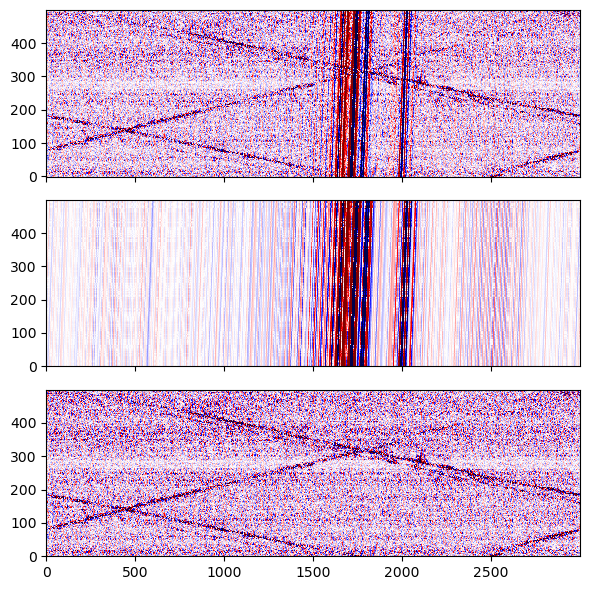

In [5]:
# patch size
nx = 128
nx_width = 16
nt = 512

if dx == 20:
    nx = 32
    nx_width = 4

nt_width = int(np.round((nx_width-1)/(60 * 10 / 36 / fs / dx)))

samples_per_epoch = 10_000

trainset = data.RealDAS(train_real_data, nx=nx, nt=nt, size=samples_per_epoch)
testset = data.RealDAS(test_real_data, nx=nx, nt=nt, size=samples_per_epoch//10)

batch_size = 32
dloader = {'train': DataLoader(trainset, batch_size=batch_size, shuffle=True), 
           'test': DataLoader(testset, batch_size=batch_size, shuffle=False)}


def kms2slowness(kms):
    kmh = kms * 3600
    ms = kmh * 1000 / 3600
    return 1 / ms

def kmh2slowness(kmh):
    ms = kmh * 1000 / 3600
    return 1 / ms

# generate a larger validation sample

np.random.seed(42)

eq = data.generate_synthetic_das(eq_test[4], dx, fs, kms2slowness(3), nx=500)[:,4300:7300]
eq /= eq.std(dim=-1, keepdim=True)

traffic = data.shift_traffic_rates(traffic_dec_test[0], dx, fs, -kmh2slowness(80))[:500,100:3300]
traffic += data.shift_traffic_rates(traffic_inc_test[2], dx, fs, kmh2slowness(100))[:500,1900:5100]

traffic = torch.from_numpy(data.bandpass(traffic, 1.0, 10.0, fs, 100).copy())
traffic /= traffic.std(dim=-1, keepdim=True)

snr = 0.5
amp = np.sqrt(snr)
sample = amp * eq  + traffic
scale = sample.std(dim=-1, keepdim=True)
sample /= scale

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6,6))
axs[0].imshow(sample.detach().cpu().numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
axs[1].imshow(eq.detach().cpu().numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
axs[2].imshow(traffic.detach().cpu().numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

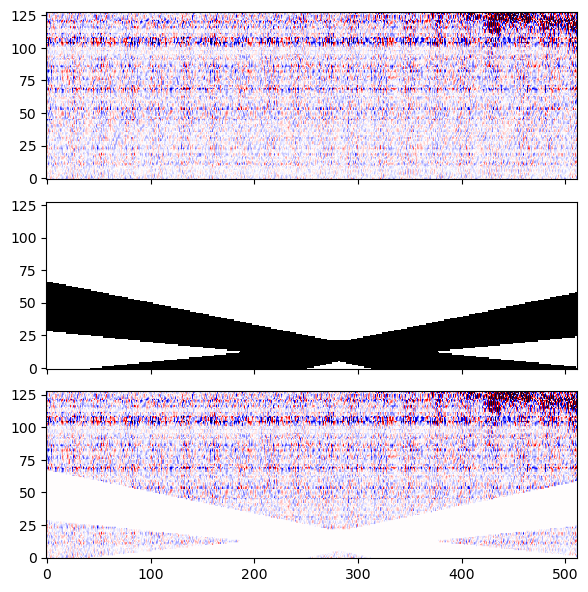

In [8]:
x = next(iter(dloader['train']))

input_mask, center_mask = masks.xmask(x, nx_width=nx_width, dx=dx, fs=fs)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6,6))
axs[0].imshow(x[0,0].detach().cpu().numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
axs[1].imshow(input_mask[0,0].detach().cpu().numpy(), origin='lower', interpolation='none', cmap='gray', aspect='auto', vmin=0, vmax=1)
axs[2].imshow((x*input_mask)[0,0].detach().cpu().numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

In [9]:
def step(model, x, loss_fn, hist, optimizer=None):
    sample = x
    sample = sample.float().to(device)
    
    loss, out, target_mask, center_mask = loss_fn(model, sample)
    
    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    hist['loss'].append(loss.item())
    

def train(model, dloader, loss_fn, optimizer, nx, nt, nx_width, n_epochs=50, valdata=None, testdata=None, name=""):
    
    pbar0 = tqdm(range(n_epochs), position=0)
    for epoch in pbar0:
        pbar1 = tqdm(dloader['train'], position=1)
        train_hist = {'loss': []}
        model.train()
        for x in pbar1:
            step(model, x, loss_fn, train_hist, optimizer)
            pbar1.set_description('[train] loss: {:.6f}'.format(train_hist['loss'][-1]))
        
        with torch.no_grad():
            model.eval()
            val_hist = {'loss': []}

            for x in dloader['test']:
                step(model, x, loss_fn, val_hist)
            
            if valdata is not None:
                valdata_rec = torch.zeros_like(valdata[0])
                for i, vdata in enumerate(valdata[0]):
                    valdata_rec[i] = inference.xreconstruct(model, vdata, nx, nt, nx_width, batch_size=128)
        
            pbar0.set_description('[val] loss: {:.6f}; reconstruction mse: {:.6f}'.format(np.mean(val_hist['loss']), torch.mean((valdata_rec - valdata[1]/valdata[3])**2).item()))

            if (epoch + 1) % 10 == 0:
                if name != "":
                    torch.save(model.state_dict(), './ckpt/'+name+'_{:03d}.pt'.format(epoch+1))
                if (epoch + 1) % 100 == 0:
                    if testdata is not None:
                        fig, axs = plt.subplots(6, 2, sharex=True, figsize=(8,12))
                        for i, tdata in enumerate(testdata):
                            out = inference.xreconstruct(model, tdata, nx, nt, nx_width, batch_size=128)
                            out = out.detach().cpu()
                            axs[i,0].imshow(tdata.numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
                            axs[i,1].imshow(out.numpy(), origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)
                        plt.tight_layout()
                        plt.show()

In [ ]:
nx_width = 16

hidden_ch = 32
n_layers = 4

target = 'complement'
assert target in ['center', 'complement']

model = models.CN2SUNet(1, 1, hidden_ch=hidden_ch, n_layers=n_layers).to(device)
model.load_state_dict(torch.load('./ckpt/' + "CN2S-synthetic{}-".format(dx) + target + "-{:d}x{:d}-{:d}x{:d}_200.pt".format(nx, nt, nx_width, nt_width)))

optimizer = optim.Adam(model.parameters(), lr=1e-4)
            
def loss_fn(model, x):
    
    bs = x.shape[0]
    center = torch.cat([torch.randint(0, nx, (bs,1)),
                        torch.randint(0, nt, (bs,1))], dim=1)

    input_mask, center_mask = masks.xmask(x, center, nx_width=nx_width, dx=dx, fs=fs)
    
    if target == 'center':
        target_mask = center_mask
    else:
        target_mask = (1 - input_mask)

    out = model(input_mask * x)
    loss = torch.mean(torch.sum((target_mask * (out - x))**2, dim=(1,2,3)) / torch.sum(target_mask, dim=(1,2,3)))
    return loss, out, target_mask, center_mask

name = "CN2S-finetuned{}-".format(dx) + target + "-{:d}x{:d}-{:d}x{:d}".format(nx, nt, nx_width, nt_width)
train(model, dloader, loss_fn, optimizer, nx=nx, nt=nt, nx_width=nx_width, 
      n_epochs=200, valdata=(sample[None,:], eq[None,:], traffic[None,:], scale[None,:]), testdata=test_data, name=name)